# Capstone Project - Toronto Subway Analysis
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project, we will analyze the **Subway Stations of Toronto**, Canada on the basis of **Venues** around them. Toronto is Canada’s largest city and a world leader in such areas as business, finance, technology, entertainment and culture. With a recorded population of 2,731,571 in 2016, it is the most populous city in Canada and the fourth most populous city in North America. The Toronto subway is a rapid transit system serving Toronto and the neighbouring city of Vaughan in Ontario, Canada, operated by the Toronto Transit Commission (TTC)

This report will be helpful to people who are new to Toronto - Immigrants, people moved from different cities.

The Toronto subway has 75 stations. As there a lot of venues around any subway station and some stations are at short distance from each other, we will focus on top 100 venues within a radius of 300 meters.

Any resident in Toronto uses subway frequently and people who new to the city don't know what kind of places they can't expect or find around a subway station. Moreover, such information is not readily avaiable.

When we consider all these, we can use data science tools and machine learning algorithms to create a map and  chart where all subway station is clustered according to the venues around them.

## Data <a name="data"></a>

Based on definition of our problem, we need following dataset:
* list of all subway stations in Toronto - We will get this data by Webscraping the following **Wikipedia** page, https://en.wikipedia.org/wiki/List_of_Toronto_subway_stations 
* Geographic coordinates of all subway stations - we will get this data using **Nominatim API**
* Popular venues arounds stations - We will get this data using **FourSquare API**

### Subway Stations

Let's get latitude & longitude coordinates of all subway stations

In [1]:
import pandas as pd
url = 'https://en.wikipedia.org/wiki/List_of_Toronto_subway_stations'
df_list = pd.read_html(url)
df=df_list[1]
Subwaystn=df[['Station']]+ ', Toronto'
Subwaystn.head()

,Station
0,"Finch, Toronto"
1,"North York Centre, Toronto"
2,"Sheppard–Yonge, Toronto"
3,"York Mills, Toronto"
4,"Lawrence, Toronto"


In [2]:
# We know Highway 407 Subway is in Vaughan,not in Toronto so we will update Station name
Subwaystn.loc[Subwaystn['Station'] == 'Highway 407, Toronto'] = 'Highway 407, Vaughan'

In [3]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

Solving environment: done

# All requested packages already installed.



In [4]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ttc_subway")
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
# 2- - create location column
Subwaystn['location'] = Subwaystn['Station'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
Subwaystn['point'] = Subwaystn['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
Subwaystn[['latitude', 'longitude', 'altitude']] = pd.DataFrame(Subwaystn['point'].tolist(), index=df.index)
Subwaystn.head()

,Station,location,point,latitude,longitude,altitude
0,"Finch, Toronto","(Finch, Yonge Street, Willowdale, North York, ...","(43.7812974, -79.4158993, 0.0)",43.781297,-79.415899,0.0
1,"North York Centre, Toronto","(North York Centre, Yonge Street, Willowdale, ...","(43.7686787, -79.4126298, 0.0)",43.768679,-79.412630,0.0
2,"Sheppard–Yonge, Toronto","(Sheppard-Yonge, 20, Sheppard Avenue West, Wil...","(43.7614518, -79.4109148, 0.0)",43.761452,-79.410915,0.0
3,"York Mills, Toronto","(York Mills, Wilson Avenue, St. John, Don Vall...","(43.7440391, -79.406657, 0.0)",43.744039,-79.406657,0.0
4,"Lawrence, Toronto","(Lawrence, Wanless Avenue, Lawrence Park, Don ...","(43.7263483, -79.4024743, 0.0)",43.726348,-79.402474,0.0


In [5]:
stn_geo=Subwaystn.drop(['location','point','altitude'],axis=1)
stn_geo.head()

,Station,latitude,longitude
0,"Finch, Toronto",43.781297,-79.415899
1,"North York Centre, Toronto",43.768679,-79.412630
2,"Sheppard–Yonge, Toronto",43.761452,-79.410915
3,"York Mills, Toronto",43.744039,-79.406657
4,"Lawrence, Toronto",43.726348,-79.402474


In [6]:
stn_geo.count()

Station      75
latitude     75
longitude    75
dtype: int64

In [7]:
address = 'Toronto, Canada'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [8]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library


Solving environment: done

# All requested packages already installed.



In [9]:
# create map of Toronto using latitude and longitude values
map_ttc = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(stn_geo['latitude'], stn_geo['longitude'], stn_geo['Station']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_ttc)  
    
map_ttc

In [10]:
#FourSquare Credentails
CLIENT_ID = 'HIL5YWEVVIAGZ3RE0YO0SI2324RVF13PCK1QPUWKIUCK1J5Q' # Foursquare ID
CLIENT_SECRET = '5RDF33B0MQ5DZ35ZIT3YXGDRPRAYUVKBB0VPEGPRGF2Y33AT' # Foursquare Secret
VERSION ='20210101 ' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

## Venues around Subway Stations

In [11]:
#Function to get 100 venues nearby Subways in 300 meters
def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Subway Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
import requests
Subway_venues = getNearbyVenues(names=stn_geo['Station'],
                                   latitudes=stn_geo['latitude'],
                                   longitudes=stn_geo['longitude']
                                  )

Finch, Toronto
North York Centre, Toronto
Sheppard–Yonge, Toronto
York Mills, Toronto
Lawrence, Toronto
Eglinton, Toronto
Davisville, Toronto
St. Clair, Toronto
Summerhill, Toronto
Rosedale, Toronto
Bloor–Yonge, Toronto
Wellesley, Toronto
College, Toronto
Dundas, Toronto
Queen, Toronto
King, Toronto
Union, Toronto
St. Andrew, Toronto
Osgoode, Toronto
St. Patrick, Toronto
Queen's Park, Toronto
Museum, Toronto
St. George, Toronto
Spadina, Toronto
Dupont, Toronto
St. Clair West, Toronto
Eglinton West, Toronto
Glencairn, Toronto
Lawrence West, Toronto
Yorkdale, Toronto
Wilson, Toronto
Sheppard West, Toronto
Downsview Park, Toronto
Finch West, Toronto
York University, Toronto
Pioneer Village, Toronto
Highway 407, Vaughan
Vaughan Metropolitan Centre, Toronto
Kipling, Toronto
Islington, Toronto
Royal York, Toronto
Old Mill, Toronto
Jane, Toronto
Runnymede, Toronto
High Park, Toronto
Keele, Toronto
Dundas West, Toronto
Lansdowne, Toronto
Dufferin, Toronto
Ossington, Toronto
Christie, Toronto
B

In [13]:
print(Subway_venues.shape)
Subway_venues.head()

(1734, 7)


,Subway Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Finch, Toronto",43.781297,-79.415899,Pyung Won House,43.779386,-79.415511,Korean Restaurant
1,"Finch, Toronto",43.781297,-79.415899,Burrito Place,43.781258,-79.415801,Burrito Place
2,"Finch, Toronto",43.781297,-79.415899,Jungsoo Nae 정수네,43.783590,-79.416480,Korean Restaurant
3,"Finch, Toronto",43.781297,-79.415899,Toronto a la Cart - Korean,43.780563,-79.415801,Food Stand
4,"Finch, Toronto",43.781297,-79.415899,Huh Ga Ne 허가네,43.779362,-79.417366,Korean Restaurant


## Methodology <a name="methodology"></a>

The main goal of this project is find a mechanism to group the subway stations together. One way of doing that is finding venues around them and see whether which subway stations have similar venues around them.

Firstly, we have prepared **dataset having list of subway stations with geographic coordinates**. Secondly, we have used **FourSquare API** to get list of top 100 venues around any subway stations in 300 meters radius.

Finally, we will analyze a combined dataset having subway stations coordinates and venues around them. We will check number of venues around subway stations in 300 meters radius using different graphs. We will also check what are the most common venues. Once we have done that, we will use **k-means clustering** to group the subway stations. This will help people to know what kind of venues they can expect any subway station and which subway stations share common features in terms of venue.

## Analysis <a name="analysis"></a>

As we have prepared **Subway_venues dataset** in required format, let's do some analysis to get the key features and attributes.

### Concentration of Venues

In [14]:
# create map of Toronto using latitude and longitude values
map_ttc_ven = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Subway_venues['Venue Latitude'], Subway_venues['Venue Longitude'], Subway_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_ttc_ven)  
    
map_ttc_ven

### Let's check counts of Venues

In [15]:
Subway_venues.groupby('Subway Station').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Subway Station,,,,,,
"Bathurst, Toronto",36,36,36,36,36,36
"Bay, Toronto",86,86,86,86,86,86
"Bayview, Toronto",19,19,19,19,19,19
"Bessarion, Toronto",8,8,8,8,8,8
"Bloor–Yonge, Toronto",25,25,25,25,25,25
...,...,...,...,...,...,...
"Wilson, Toronto",8,8,8,8,8,8
"Woodbine, Toronto",20,20,20,20,20,20
"York Mills, Toronto",12,12,12,12,12,12


In [16]:
Subway_venue_count=Subway_venues.groupby('Subway Station').count().reset_index()
Subway_venue_count=Subway_venue_count[['Subway Station','Venue Category']]
Subway_venue_count=Subway_venue_count.sort_values(by=['Venue Category'],ascending=False)

In [17]:
Subway_venue_count.head()

,Subway Station,Venue Category
1,"Bay, Toronto",86
32,"King, Toronto",75
50,"Queen, Toronto",64
17,"Dundas, Toronto",63
45,"Osgoode, Toronto",63


Text(0.5, 1.0, 'Number of Venues nearby Subway Stations (300m radius)')

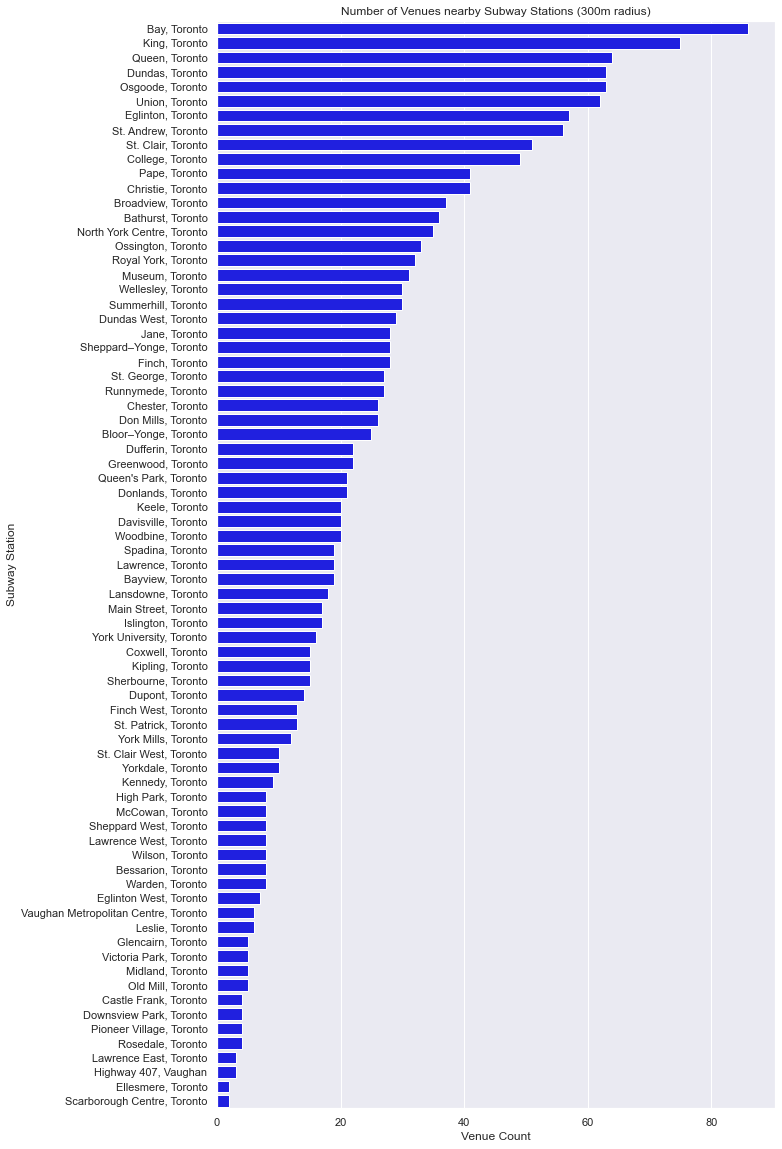

In [18]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,20)})
ax = sns.barplot(x='Venue Category', y='Subway Station', data=Subway_venue_count,color='blue')
ax.set_xlabel('Venue Count')
ax.set_title('Number of Venues nearby Subway Stations (300m radius)')

**Bay Station** has the most number of venues in 300 meters radius while **Ellesmere & Scarborough Centre Stations** have the least.

Text(0.5, 1.0, 'Top 20 Venue Category nearby Subway Station')

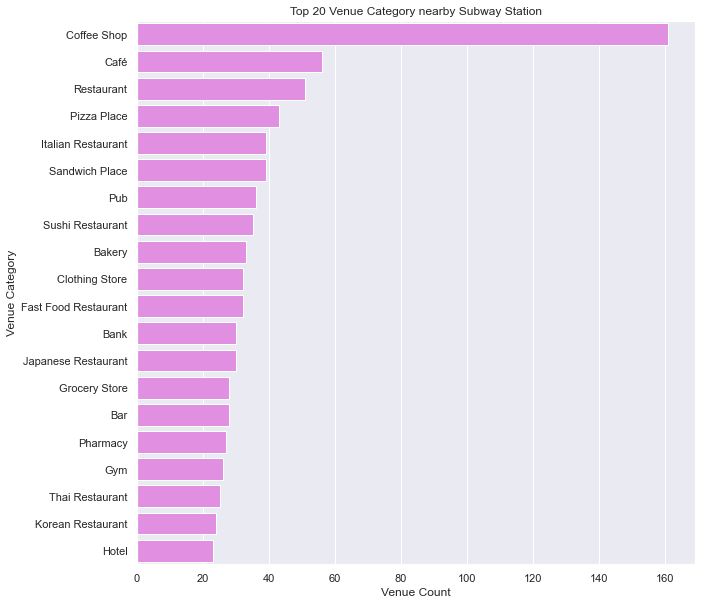

In [19]:
venue_cat_count=Subway_venues.groupby('Venue Category').count().reset_index()
venue_cat_count=venue_cat_count[['Venue Category','Subway Station']]
venue_cat_count=venue_cat_count.sort_values(by='Subway Station',ascending=False)
venue_cat_tp20=venue_cat_count.head(20)
sns.set(rc={'figure.figsize':(10,10)})
ax1 = sns.barplot(x='Subway Station', y='Venue Category', data=venue_cat_tp20,color='violet')
ax1.set_xlabel('Venue Count')
ax1.set_title('Top 20 Venue Category nearby Subway Station')

Text(0.5, 1.0, 'Bottom 20 Venue Category nearby Subway Station')

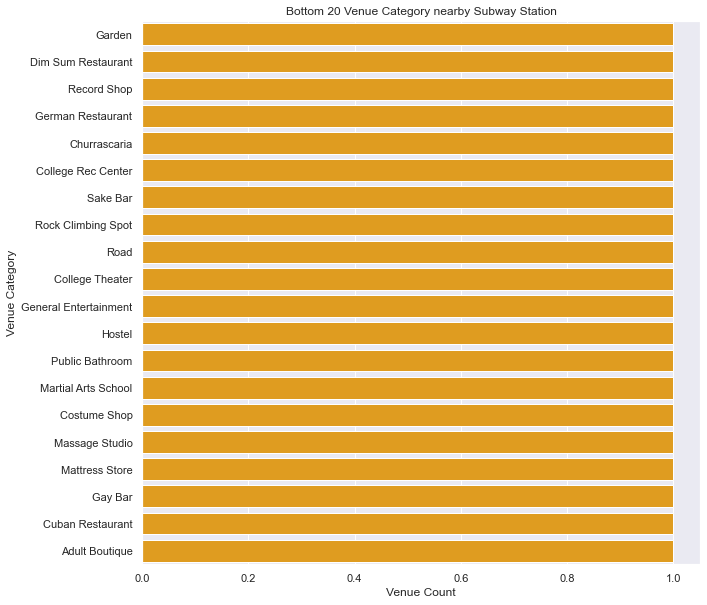

In [20]:
venue_cat_bt20=venue_cat_count.tail(20)
ax2 = sns.barplot(x='Subway Station', y='Venue Category', data=venue_cat_bt20,color='orange')
ax2.set_xlabel('Venue Count')
ax2.set_title('Bottom 20 Venue Category nearby Subway Station')

**Coffee Shop** is the most common venue across subway stations.

In [21]:
print('There are {} uniques categories.'.format(len(Subway_venues['Venue Category'].unique())))

There are 241 uniques categories.


## Let's Analyze Venues near Subway Stations

In [41]:
# one hot encoding
station_onehot = pd.get_dummies(Subway_venues[['Venue Category']], prefix="", prefix_sep="")

# add Subway Station column back to dataframe
station_onehot['Subway Station'] = Subway_venues['Subway Station'] 

# move station column to the first column
fixed_columns = [station_onehot.columns[-1]] + list(station_onehot.columns[:-1])
station_onehot = station_onehot[fixed_columns]

# drop Category columns - Train Station and Metro Station
station_onehot=station_onehot.drop(['Metro Station','Train Station'],axis=1)
station_onehot.head()

,Subway Station,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Finch, Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Finch, Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Finch, Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Finch, Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Finch, Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
station_onehot_grpd = station_onehot.groupby('Subway Station').mean().reset_index()
station_onehot_grpd

,Subway Station,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Bathurst, Toronto",0.000000,0.0,0.0,0.027778,0.0,0.00,0.0,0.027778,0.000000,...,0.0,0.0,0.027778,0.0,0.000000,0.027778,0.000000,0.0,0.000000,0.00
1,"Bay, Toronto",0.011628,0.0,0.0,0.023256,0.0,0.00,0.0,0.000000,0.011628,...,0.0,0.0,0.011628,0.0,0.011628,0.000000,0.011628,0.0,0.023256,0.00
2,"Bayview, Toronto",0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00
3,"Bessarion, Toronto",0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00
4,"Bloor–Yonge, Toronto",0.000000,0.0,0.0,0.000000,0.0,0.04,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,"Wilson, Toronto",0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00
71,"Woodbine, Toronto",0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.100000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00
72,"York Mills, Toronto",0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00
73,"York University, Toronto",0.000000,0.0,0.0,0.062500,0.0,0.00,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00


In [43]:
station_onehot_grpd.shape

(75, 240)

In [44]:
#Top 5 Venues for each Subway
num_top_venues = 5

for Subway in station_onehot_grpd['Subway Station']:
    print("----"+Subway+"----")
    temp = station_onehot_grpd[station_onehot_grpd['Subway Station'] == Subway].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst, Toronto----
                         Venue  Freq
0            Korean Restaurant  0.11
1               Ice Cream Shop  0.06
2  Eastern European Restaurant  0.06
3           Mexican Restaurant  0.06
4                Deli / Bodega  0.03


----Bay, Toronto----
                Venue  Freq
0            Boutique  0.06
1         Coffee Shop  0.06
2  Italian Restaurant  0.06
3                Café  0.06
4      Clothing Store  0.05


----Bayview, Toronto----
                Venue  Freq
0                Café  0.16
1         Coffee Shop  0.11
2    Toy / Game Store  0.05
3       Shopping Mall  0.05
4  Chinese Restaurant  0.05


----Bessarion, Toronto----
                  Venue  Freq
0           Pizza Place  0.12
1    Persian Restaurant  0.12
2           Fish Market  0.12
3  Outdoor Supply Store  0.12
4        Breakfast Spot  0.12


----Bloor–Yonge, Toronto----
                      Venue  Freq
0                      Café  0.08
1       Japanese Restaurant  0.08
2               Yoga Stu

              Venue  Freq
0       Coffee Shop  0.09
1  Ramen Restaurant  0.06
2     Shopping Mall  0.06
3              Café  0.06
4        Restaurant  0.06


----Old Mill, Toronto----
                 Venue  Freq
0                  Spa   0.2
1  American Restaurant   0.2
2                 Park   0.2
3          Event Space   0.2
4  Monument / Landmark   0.0


----Osgoode, Toronto----
                           Venue  Freq
0                    Coffee Shop  0.06
1            Japanese Restaurant  0.05
2                Thai Restaurant  0.03
3  Vegetarian / Vegan Restaurant  0.03
4                     Taco Place  0.03


----Ossington, Toronto----
                  Venue  Freq
0                  Café  0.09
1                   Pub  0.09
2           Pizza Place  0.06
3          Cocktail Bar  0.06
4  Ethiopian Restaurant  0.06


----Pape, Toronto----
              Venue  Freq
0  Greek Restaurant  0.10
1       Coffee Shop  0.07
2       Pizza Place  0.05
3  Sushi Restaurant  0.05
4     Grocery Stor

In [45]:
# Function to sort venues in Descending Order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
# Let's get Top 10 Venues for each Subway
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Subway Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
subway_venues_sorted = pd.DataFrame(columns=columns)
subway_venues_sorted['Subway Station'] = station_onehot_grpd['Subway Station']

for ind in np.arange(station_onehot_grpd.shape[0]):
    subway_venues_sorted.iloc[ind, 1:] = return_most_common_venues(station_onehot_grpd.iloc[ind, :], num_top_venues)

subway_venues_sorted.head()

,Subway Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst, Toronto",Korean Restaurant,Ice Cream Shop,Eastern European Restaurant,Mexican Restaurant,Health Food Store,Restaurant,Indie Movie Theater,Lingerie Store,School,Sandwich Place
1,"Bay, Toronto",Italian Restaurant,Boutique,Coffee Shop,Café,Spa,French Restaurant,Clothing Store,Restaurant,Hotel,Pizza Place
2,"Bayview, Toronto",Café,Coffee Shop,Indian Restaurant,Toy / Game Store,Supermarket,Restaurant,Spa,Burger Joint,Italian Restaurant,Thai Restaurant
3,"Bessarion, Toronto",Pizza Place,Outdoor Supply Store,Gas Station,Sandwich Place,Fish Market,Sporting Goods Shop,Breakfast Spot,Persian Restaurant,Flea Market,Electronics Store
4,"Bloor–Yonge, Toronto",Café,Japanese Restaurant,Yoga Studio,Mediterranean Restaurant,Salad Place,Restaurant,Caribbean Restaurant,Coffee Shop,Comic Shop,Music Venue


In [47]:
subway_venues_sorted.count()

Subway Station            75
1st Most Common Venue     75
2nd Most Common Venue     75
3rd Most Common Venue     75
4th Most Common Venue     75
5th Most Common Venue     75
6th Most Common Venue     75
7th Most Common Venue     75
8th Most Common Venue     75
9th Most Common Venue     75
10th Most Common Venue    75
dtype: int64

### Subway Cluster Analysis

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
!conda install -c districtdatalabs yellowbrick --yes
from yellowbrick.cluster import KElbowVisualizer

Solving environment: done

# All requested packages already installed.



In [49]:
X = station_onehot_grpd.drop('Subway Station', 1)
X.head()

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.000000,0.0,0.0,0.027778,0.0,0.00,0.0,0.027778,0.000000,0.0,...,0.0,0.0,0.027778,0.0,0.000000,0.027778,0.000000,0.0,0.000000,0.00
1,0.011628,0.0,0.0,0.023256,0.0,0.00,0.0,0.000000,0.011628,0.0,...,0.0,0.0,0.011628,0.0,0.011628,0.000000,0.011628,0.0,0.023256,0.00
2,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00
3,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00
4,0.000000,0.0,0.0,0.000000,0.0,0.04,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.04


In [50]:
#from sklearn import preprocessing
#X = preprocessing.StandardScaler().fit(X).transform(X)

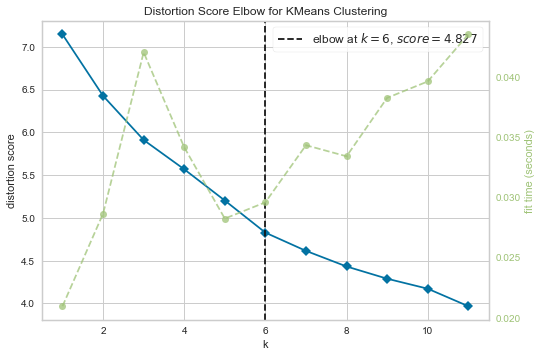

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [52]:
# run k-means clustering
kclusters=6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 0, 0, 0, 1, 0, 0, 4], dtype=int32)

In [53]:
kmeans.labels_.shape

(75,)

In [54]:
# add clustering labels
subway_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)


In [55]:
stn_merged = stn_geo.rename(columns={"Station": "Subway Station"})

# merge subway_venues_sorted with stn_geo to add latitude/longitude for each neighborhood
stn_merged = stn_merged.join(subway_venues_sorted.set_index('Subway Station'), on='Subway Station')

stn_merged.head() # check the last columns!

,Subway Station,latitude,longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Finch, Toronto",43.781297,-79.415899,4,Korean Restaurant,Coffee Shop,Bus Station,Sandwich Place,Café,Restaurant,Japanese Restaurant,Thai Restaurant,Bank,Sake Bar
1,"North York Centre, Toronto",43.768679,-79.412630,0,Coffee Shop,Shopping Mall,Restaurant,Café,Sushi Restaurant,Ramen Restaurant,Japanese Restaurant,Juice Bar,Bubble Tea Shop,Sandwich Place
2,"Sheppard–Yonge, Toronto",43.761452,-79.410915,4,Coffee Shop,Japanese Restaurant,Burger Joint,Restaurant,Grocery Store,Bar,Fast Food Restaurant,Fried Chicken Joint,Breakfast Spot,Ramen Restaurant
3,"York Mills, Toronto",43.744039,-79.406657,4,Restaurant,Coffee Shop,Thai Restaurant,Gym,Burrito Place,Sandwich Place,Intersection,Food Court,Optical Shop,Park
4,"Lawrence, Toronto",43.726348,-79.402474,4,Coffee Shop,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Bank,Pool,Gastropub,Ice Cream Shop,Supermarket,Pizza Place


In [120]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow =['violet','black','red','blue','orange','green'] #[colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,one,two in zip(stn_merged['latitude'], stn_merged['longitude'], stn_merged['Subway Station'], stn_merged['Cluster Label'], stn_merged['1st Most Common Venue'],stn_merged['2nd Most Common Venue']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+ '-'+ one+','+two,  parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

### Let's check the clusters

#### Cluster 0

In [109]:
stn_merged[stn_merged['Cluster Label']==0]

,Subway Station,latitude,longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"North York Centre, Toronto",43.768679,-79.412630,0,Coffee Shop,Shopping Mall,Restaurant,Café,Sushi Restaurant,Ramen Restaurant,Japanese Restaurant,Juice Bar,Bubble Tea Shop,Sandwich Place
8,"Summerhill, Toronto",43.681678,-79.390504,0,Italian Restaurant,Spa,Sushi Restaurant,Butcher,Dessert Shop,Furniture / Home Store,Sporting Goods Shop,Beer Store,Coffee Shop,Shoe Store
10,"Bloor–Yonge, Toronto",43.670786,-79.385687,0,Café,Japanese Restaurant,Yoga Studio,Mediterranean Restaurant,Salad Place,Restaurant,Caribbean Restaurant,Coffee Shop,Comic Shop,Music Venue
11,"Wellesley, Toronto",43.665524,-79.383801,0,Sushi Restaurant,Gay Bar,Beer Bar,Mexican Restaurant,Japanese Restaurant,Ethiopian Restaurant,Bookstore,Juice Bar,Pub,Breakfast Spot
18,"Osgoode, Toronto",43.650802,-79.386541,0,Coffee Shop,Japanese Restaurant,Asian Restaurant,Burrito Place,Hotel,Steakhouse,Café,Sushi Restaurant,Taco Place,Thai Restaurant
19,"St. Patrick, Toronto",43.654820,-79.388274,0,Bubble Tea Shop,Neighborhood,Movie Theater,Ramen Restaurant,Tea Room,Bar,Pub,Coffee Shop,Sushi Restaurant,Poke Place
21,"Museum, Toronto",43.667092,-79.394207,0,Sandwich Place,Boutique,Restaurant,Clothing Store,Steakhouse,Sporting Goods Shop,Salon / Barbershop,Cocktail Bar,Coffee Shop,College Theater
24,"Dupont, Toronto",43.674705,-79.406983,0,Sandwich Place,Pizza Place,Indian Restaurant,Middle Eastern Restaurant,Café,Liquor Store,Pub,BBQ Joint,Donut Shop,Burger Joint
27,"Glencairn, Toronto",43.708712,-79.440685,0,Pizza Place,Playground,Bakery,Japanese Restaurant,Filipino Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
33,"Finch West, Toronto",43.763971,-79.491592,0,Pizza Place,Coffee Shop,Massage Studio,Fast Food Restaurant,Falafel Restaurant,Caribbean Restaurant,Sushi Restaurant,Road,Bank,Japanese Restaurant


#### Cluster 1

In [86]:
stn_merged[stn_merged['Cluster Label']==1]

,Subway Station,latitude,longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Rosedale, Toronto",43.678356,-79.380746,1,Park,Bike Trail,Campground,Yoga Studio,Ethiopian Restaurant,Food Stand,Food Court,Food & Drink Shop,Flower Shop,Flea Market
54,"Castle Frank, Toronto",43.673509,-79.369031,1,Park,Convenience Store,Yoga Studio,Electronics Store,Food Stand,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market


#### Cluster 2

In [85]:
stn_merged[stn_merged['Cluster Label']==2]

,Subway Station,latitude,longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,"Sheppard West, Toronto",43.749299,-79.462248,2,Bus Station,Gym Pool,Men's Store,Furniture / Home Store,Gym / Fitness Center,Fish Market,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
36,"Highway 407, Vaughan",43.783314,-79.523088,2,Bus Station,Public Bathroom,Yoga Studio,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
63,"Victoria Park, Toronto",43.694870,-79.288797,2,Baseball Field,Convenience Store,Bus Station,Golf Course,Yoga Studio,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market
65,"Kennedy, Toronto",43.732429,-79.263753,2,Hockey Arena,Grocery Store,Light Rail Station,Convenience Store,Bus Line,Bus Station,Discount Store,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
66,"Lawrence East, Toronto",43.750499,-79.270186,2,Accessories Store,Bus Station,Light Rail Station,Fountain,Food Stand,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market


#### Cluster 3

In [87]:
stn_merged[stn_merged['Cluster Label']==3]

,Subway Station,latitude,longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
67,"Ellesmere, Toronto",43.766807,-79.276286,3,Gym / Fitness Center,Light Rail Station,Yoga Studio,Electronics Store,Food Stand,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market


#### Cluster 4

In [110]:
stn_merged[stn_merged['Cluster Label']==4]

,Subway Station,latitude,longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Finch, Toronto",43.781297,-79.415899,4,Korean Restaurant,Coffee Shop,Bus Station,Sandwich Place,Café,Restaurant,Japanese Restaurant,Thai Restaurant,Bank,Sake Bar
2,"Sheppard–Yonge, Toronto",43.761452,-79.410915,4,Coffee Shop,Japanese Restaurant,Burger Joint,Restaurant,Grocery Store,Bar,Fast Food Restaurant,Fried Chicken Joint,Breakfast Spot,Ramen Restaurant
3,"York Mills, Toronto",43.744039,-79.406657,4,Restaurant,Coffee Shop,Thai Restaurant,Gym,Burrito Place,Sandwich Place,Intersection,Food Court,Optical Shop,Park
4,"Lawrence, Toronto",43.726348,-79.402474,4,Coffee Shop,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Bank,Pool,Gastropub,Ice Cream Shop,Supermarket,Pizza Place
5,"Eglinton, Toronto",43.706123,-79.398530,4,Coffee Shop,Fast Food Restaurant,Restaurant,Movie Theater,Pub,Bookstore,Salad Place,Bank,Plaza,Buffet
6,"Davisville, Toronto",43.697936,-79.397291,4,Coffee Shop,Pub,Sushi Restaurant,Gastropub,Furniture / Home Store,Restaurant,Japanese Restaurant,Italian Restaurant,Irish Pub,Bank
7,"St. Clair, Toronto",43.687951,-79.393695,4,Coffee Shop,Italian Restaurant,Grocery Store,Sushi Restaurant,Thai Restaurant,Pizza Place,Sandwich Place,Café,Restaurant,Bank
12,"College, Toronto",43.660662,-79.382795,4,Coffee Shop,Burger Joint,Hotel,Italian Restaurant,Sandwich Place,Falafel Restaurant,Movie Theater,Pharmacy,Yoga Studio,Park
13,"Dundas, Toronto",43.656537,-79.381022,4,Coffee Shop,Clothing Store,Diner,Fast Food Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Café,Cocktail Bar,Italian Restaurant,Ice Cream Shop
14,"Queen, Toronto",43.652908,-79.379458,4,Clothing Store,Coffee Shop,Cosmetics Shop,Gym,Theater,Fast Food Restaurant,Lingerie Store,Breakfast Spot,Italian Restaurant,Hotel


#### Cluster 5

In [79]:
stn_merged[stn_merged['Cluster Label']==5]

,Subway Station,latitude,longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,"Scarborough Centre, Toronto",43.747502,-79.284828,5,Hookah Bar,Bus Station,Creperie,Food Stand,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop


## Results and Discussion <a name="results"></a>

From the analysis, we can see that subway stations in downtown area have more number of venues around them. **Bay, King and Queen** subway stations have highest number of venues while **Scarborough center and Ellesmere** have the least.

On further analyis, we found that **Coffee shops and Cafe** are the most common venue around subway while **Garden and Hostel** are some of the least common spots. After doing the cluster analysis of venues around subway stations, we gathered that the elbow is for **k=6** which means we can group the subway stations in **6 Clsuters** namely - Cluster 0, Cluster 1, Cluster 2, Cluster 3, Cluster 4 and Cluster 5. Most of the subway stations are grouped into either **Cluster 0 and Cluster 4**.

On checking the most common venues in Clusters, we found that the following

**Cluster 0 (Green) -** Pizza place, Sandwich, Coffee shops, Cafe and Bar place are most common venues. 

**Cluster 4 (Blue) -** Coffee shops and Clothing Store are most common venues. 

**Cluster 1 (Violet) -** Park is the most common venue. Rosedale and Castle Frank subways are there.

**Cluster 2 (Black) -** It has 5 subway stations. Bus station is the most common venue. Baseball field and Hockey arena are also there.

**Cluster 3 (Red) -** Gym / Fitness Centre is the most common venue. Only Ellesmere subway is there.

**Cluster 5 (Orange) -** Hookah Bar is the most common venue. Only Scarborough Centre is there.



## Conclusion <a name="conclusion"></a>

Subway is the most common mode of transport in Toronto. From our analysis, we have come to conclusion that subway stations can be grouped into 6 categories based on venues around them. People who are looking for **Pizza place and Sandwich** venues can visit explore venues around Subway in Cluster 0. People who are looking for **Clothing stores** can visit explore venues around Subway in Cluster 4. Anyone looking for **Coffee shops** can find them around subways in Cluster 0 and Cluster 4. There are only **9 Subway stations out of 75**, which do not fall under Cluster 0 or Clsuter 4. Cluster 1, Rosedale and Castle Frank subways, have **Park** as the most common venue around them while Cluster 3, Ellesmere Subway, has **Gym/Fitness Centre** as the most common venue. Cluster 2 has 5 subway stations; **Bus station, Baseball field and Hockey arena** are common venues. **Hookah Bar** is the most common venue around Scarborough Centre, which is in Cluster 5. These clusters provides insights into what want kind of venues you can expect around any subway stations. Anyone new to Toronto can use these insights to explore the venues easily without going too far from any subway station.